In [1]:
import numpy as np
import matplotlib.pyplot as plt

from symdisc import (
    LSE,
    getExtendedFeatureMatrix,
    discover_symmetry_coeffs,
    generate_euclidean_killing_fields,
    generate_euclidean_killing_fields_with_names
)

## Demo 1: The Circle

In [2]:
rng = np.random.default_rng(0)

# ---- Circle in R^3 (z=0), param t ~ N(0,1)
t = rng.normal(0.0, 1.0, size=1000)
X = np.column_stack([np.cos(t), np.sin(t), np.zeros_like(t)])  # (N,3)

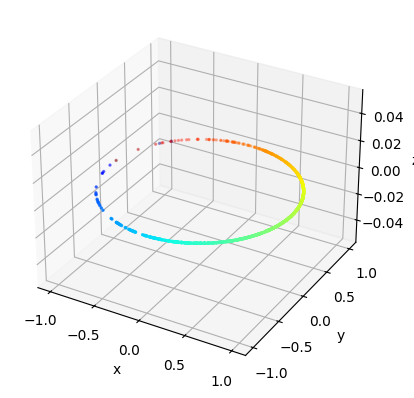

In [3]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=2, c=t, cmap="jet")
ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
plt.show()

In [4]:
lse = LSE(
    mode="polynomial",
    degree=3,
    include_bias=False,
    use_incremental=False,
    lowvar_policy="relative",
    rel_tol=1e-8,
    n_components=None,
    svd_solver="randomized",
    random_state=0,
    )

In [5]:
lse.fit(X);

In [6]:
# Constraint Jacobians J_g(X): (N, r, d)
Jg = lse.get_constraint_jacobian(X)

In [7]:
# Euclidean Killing fields in ambient R^3
kvs, names = generate_euclidean_killing_fields_with_names(d=X.shape[1])

# Build extended feature matrix A for invariance discovery
A, info = getExtendedFeatureMatrix(X, Jg, kvs, normalize_rows=True)
# A: shape (N*m, q). Here m=r (# constraints), q=#vector fields

In [8]:
# SVD-based symmetry coefficients (columns)
C, svals = discover_symmetry_coeffs(A, rtol=1e-8)
print("Discovered coefficient vectors shape:", C.shape)
print("Small singular values:", svals)

Discovered coefficient vectors shape: (6, 1)
Small singular values: [6.46698664e-13]


In [9]:
C

array([[-1.99093070e-16],
       [-1.37443199e-16],
       [-2.00524729e-18],
       [-1.00000000e+00],
       [ 2.79801321e-17],
       [ 3.64823976e-17]])

In [10]:
names

['T_0', 'T_1', 'T_2', 'R_0_1', 'R_0_2', 'R_1_2']

In [11]:
#T_i: translation in the i-th direction
#R_i_j: rotation in the (i,j) plane

## Demo 2: The Sphere

In [12]:
def sample_uniform_s2_numpy(n=2000, rng=None):
    """
    Uniformly sample points on S^2 using a simple normalized Gaussian method.
    """
    if rng is None:
        rng = np.random.default_rng()
    X = rng.normal(size=(n, 3))
    X = X / np.linalg.norm(X, axis=1, keepdims=True)
    return X

def sample_uniform_s2_geomstats(n=2000, rng=None):
    """
    Try to uniformly sample points on S^2 using geomstats, if available.
    Falls back to the NumPy sampler if geomstats isn't installed/usable.
    """
    if rng is None:
        rng = np.random.default_rng()

    try:
        import geomstats.backend as gs
        from geomstats.geometry.hypersphere import Hypersphere

        sphere = Hypersphere(dim=2)
        # Many geomstats versions expose random_point
        if hasattr(sphere, "random_point"):
            X = sphere.random_point(n_samples=n)
            return np.array(X, dtype=float)

        # Fallback to NumPy sampler if API differs
        raise AttributeError("geomstats Hypersphere.random_point not found")

    except Exception as e:
        print("geomstats sampling unavailable, falling back to NumPy sampler. Reason:", repr(e))
        return sample_uniform_s2_numpy(n=n, rng=rng)

In [13]:
def main():
    rng = np.random.default_rng(0)

    # 1) Sample the 2-sphere in R^3
    X = sample_uniform_s2_geomstats(n=4000, rng=rng)  # will fallback if needed
    assert X.shape[1] == 3

    # 2) Visualize (optional)
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=1, c=X[:, 2], cmap="jet")
    ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
    ax.set_title("Uniform samples on S^2")
    plt.show(block=False)

    # 3) LSE on polynomial features
    lse = LSE(
        mode="polynomial",
        degree=3,
        include_bias=False,
        use_incremental=False,
        lowvar_policy="relative",
        rel_tol=1e-8,
        n_components=None,
        svd_solver="randomized",
        random_state=0,
    ).fit(X)

    # 4) Constraint Jacobians J_g(X): (N, r, d)
    Jg = lse.get_constraint_jacobian(X)

    # 5) Ambient Euclidean Killing fields in R^3
    kvs = generate_euclidean_killing_fields(d=X.shape[1])

    # 6) Build extended feature matrix A and discover invariances
    A, info = getExtendedFeatureMatrix(X, Jg, kvs, normalize_rows=True)
    C, svals = discover_symmetry_coeffs(A, rtol=1e-8)

    print("Extended feature matrix A shape:", A.shape)
    print("Discovered coefficient vectors shape:", C.shape)  # (q, r)
    print("Small singular values:", svals)
    print(C)

    #plt.show() 

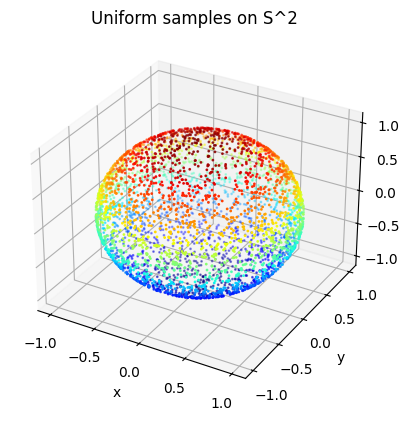

Extended feature matrix A shape: (16000, 6)
Discovered coefficient vectors shape: (6, 3)
Small singular values: [1.17996758e-12 5.77046533e-12 1.02486827e-11]
[[-1.15499500e-16 -1.10177481e-15 -2.47754725e-16]
 [-5.65710443e-17  3.51474057e-16 -1.64359444e-15]
 [-2.11712179e-16 -1.00892672e-16 -8.01234362e-16]
 [ 2.89781167e-02 -4.12705507e-01  9.10403445e-01]
 [ 3.82193672e-01  8.46155269e-01  3.71415209e-01]
 [ 9.23627775e-01 -3.37187522e-01 -1.82253419e-01]]


In [14]:
main()